In [195]:
#Paquetes necesarios
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 230
rng = np.random.default_rng()
                

#### 1) Considere un activo cuyo precio sigue un camino aleatorio dado por: $dS = \mu Sdt+\sigma SdX$ donde dX es una variable aleatoria con distribución normal de media nula y varianza dt (proceso de Wiener). Utilice un entorno computacional para simular este camino aleatorio con diferentes valores de la tendencia mu y de la desviación estándar sigma, a partir de un precio inicial So. Usted debe realizar un programa que le permita al usuario cambiar estos parámetros y ejecutar la simulación para obtener otros posibles resultados.

Por favor introducir parámetros iniciales: 

In [206]:
#PARÁMETROS INICIALES 
risk_free = 0.01
mu =0.06 #Rendimientos promedio
P_inicial =100 #Precio inicial del activo
sigma =0.2 #Desviacion estandar de los retornos
T = 120 #Dias de observación
E1= 80
E2 = 150

In [207]:
def simulacion(T,  mu, sigma, P_inicial, paso = 1 ): 
    dt = float(paso)/T
    t = np.linspace(0,paso,T)
    W = rng.standard_normal(size = T) 
    W = np.cumsum(W)*np.sqrt(dt)
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S =  P_inicial*np.exp(X)
    S = np.insert(S, 0,P_inicial)
    return S

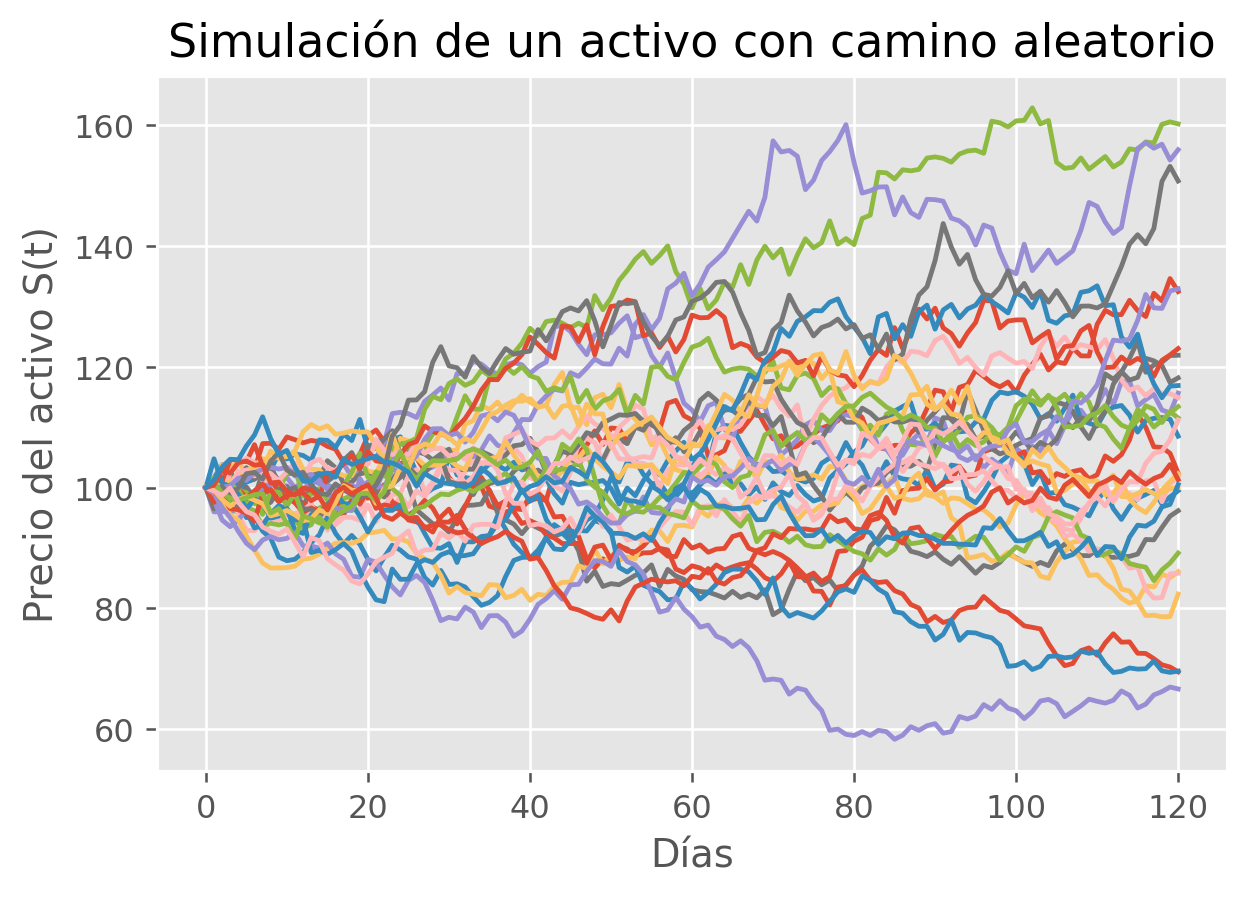

In [208]:
caminos = pd.DataFrame(index = range(T+1))
for camino in range(30):    
    y = pd.Series(
        simulacion(T, mu, sigma, P_inicial)).rename("Camino" +str(camino ))    
    caminos = pd.merge(caminos,y, left_index=True, right_index=True)

caminos.plot(title = "Simulación de un activo con camino aleatorio", xlabel= "Días", ylabel="Precio del activo S(t)", legend = False
            )

plt.savefig("Simulaciones_Activo.png", dpi =200)


#### Formula de una opción de doble barrera europea

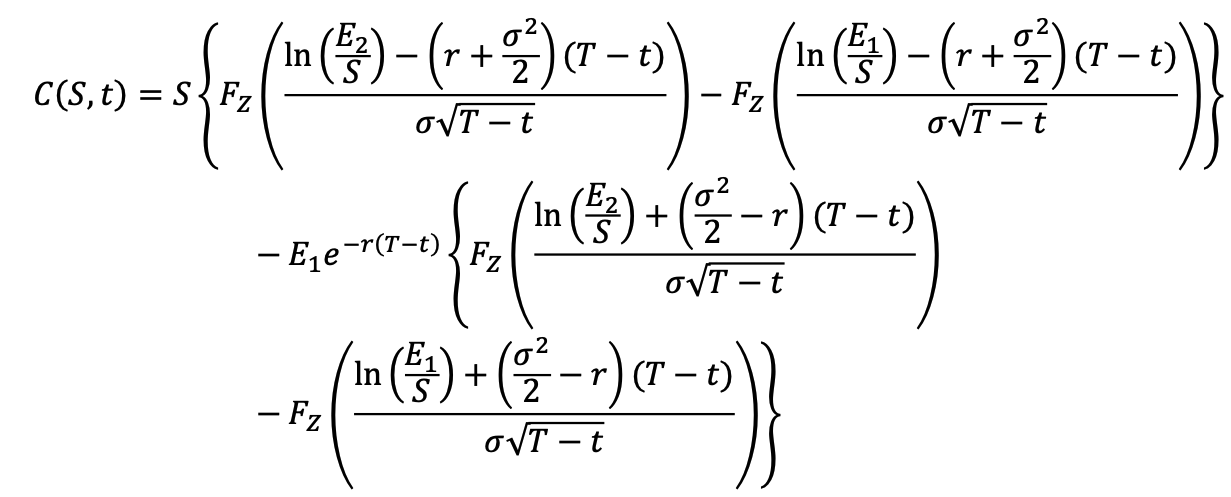

In [209]:
from mpl_toolkits import mplot3d
import scipy.stats as stats
cdf = stats.norm.cdf

In [210]:
#Valores
def f(S, t, E1, E2, T, sigma, r):
    infinitos = np.full(S.shape, np.Inf)
    denominador = sigma * np.sqrt(T-t)

    
    
    d1 = np.divide((np.log(E2/S) - (r+(sigma**2)/2)*(T-t) ), denominador, 
                  out=np.full(S.shape, np.Inf), where=denominador!=0)
    d2 = np.divide((np.log(E1/S) - (r+(sigma**2)/2)*(T-t)), denominador, 
                  out=np.full(S.shape, np.NINF), where=denominador!=0)    

    d3 = np.divide((np.log(E2/S) + ((sigma**2)/2-r)*(T-t)), denominador, 
                  out=np.full(S.shape, np.Inf), where=denominador!=0)
    d4 = np.divide((np.log(E1/S) + ((sigma**2)/2-r)*(T-t)), denominador, 
                  out=np.full(S.shape, np.NINF), where=denominador!=0) 

    C = S*(cdf(d1) - cdf(d2)) - E1*np.exp(-r*(T-t))*(cdf(d3)-cdf(d4))
    
    

    return np.where(((S<E1)|(S>E2))&(t==T), 0, C)

finura = T*5
lim= 30
S = np.linspace(E1-lim, E2+20, (E2-E1)*4)
t = np.linspace(0, T,finura, endpoint = True)
S,t = np.meshgrid(S,t)
Z = f(S, t, E1, E2, T, sigma=sigma, r=risk_free)



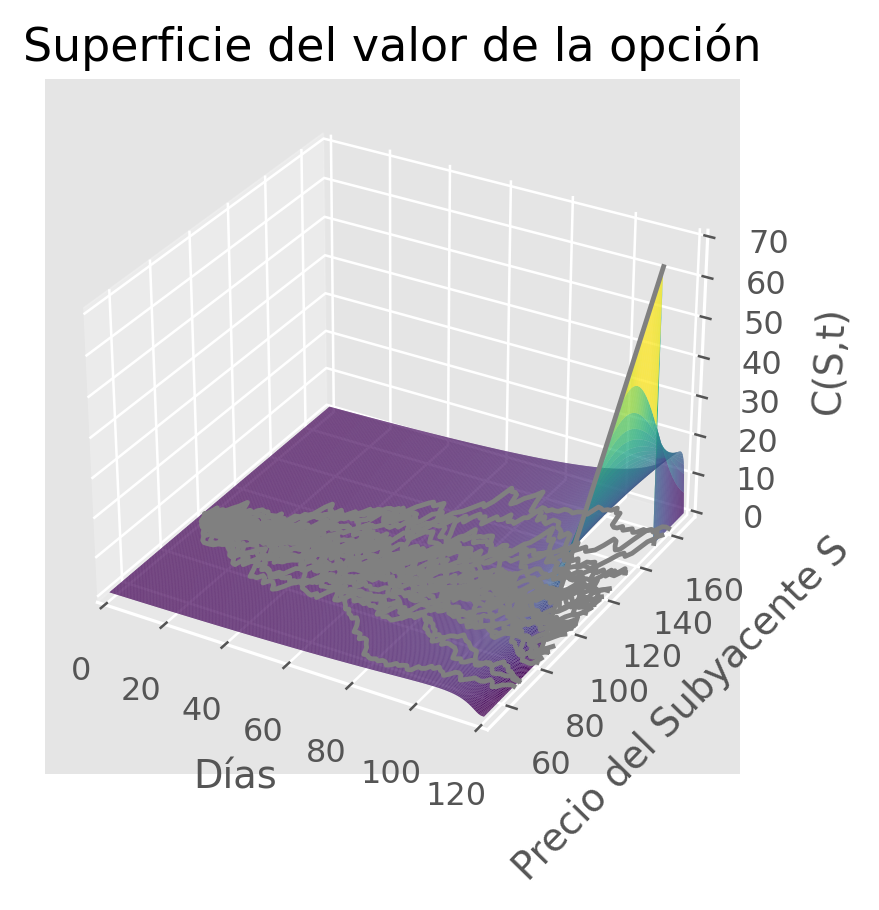

In [211]:

#%matplotlib notebook

ax = plt.axes(projection='3d', xlim = (0,T), ylim= (E1-lim,E2+20))
ax.plot_surface(t, S, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_zlabel("C(S,t)")
ax.set_title('Superficie del valor de la opción')
ax.set_xlabel("Días"); ax.set_ylabel("Precio del Subyacente S")
finura = (E2-E1)
#Frontera en t=T
s =np.linspace(E1, E2, finura)
xline = np.full(shape = (finura,), fill_value= T)
zline = np.where( (s<E1) | (s>E2),0, s-E1)

for i in range(caminos.shape[1]):

    ax.plot3D(caminos.axes[0].tolist(), caminos.iloc[:,i], 0, 'gray')
ax.plot3D(xline, s, zline, 'gray')

plt.savefig("Superficie.png", dpi =300)





Hacer un portafolio

##### Portafolio

In [212]:
#Activo sin riesgo
sin_riesgo = [1]
for i in range(120):
    sin_riesgo.append(sin_riesgo[-1]*(1+risk_free))
sin_riesgo =np.array(sin_riesgo)

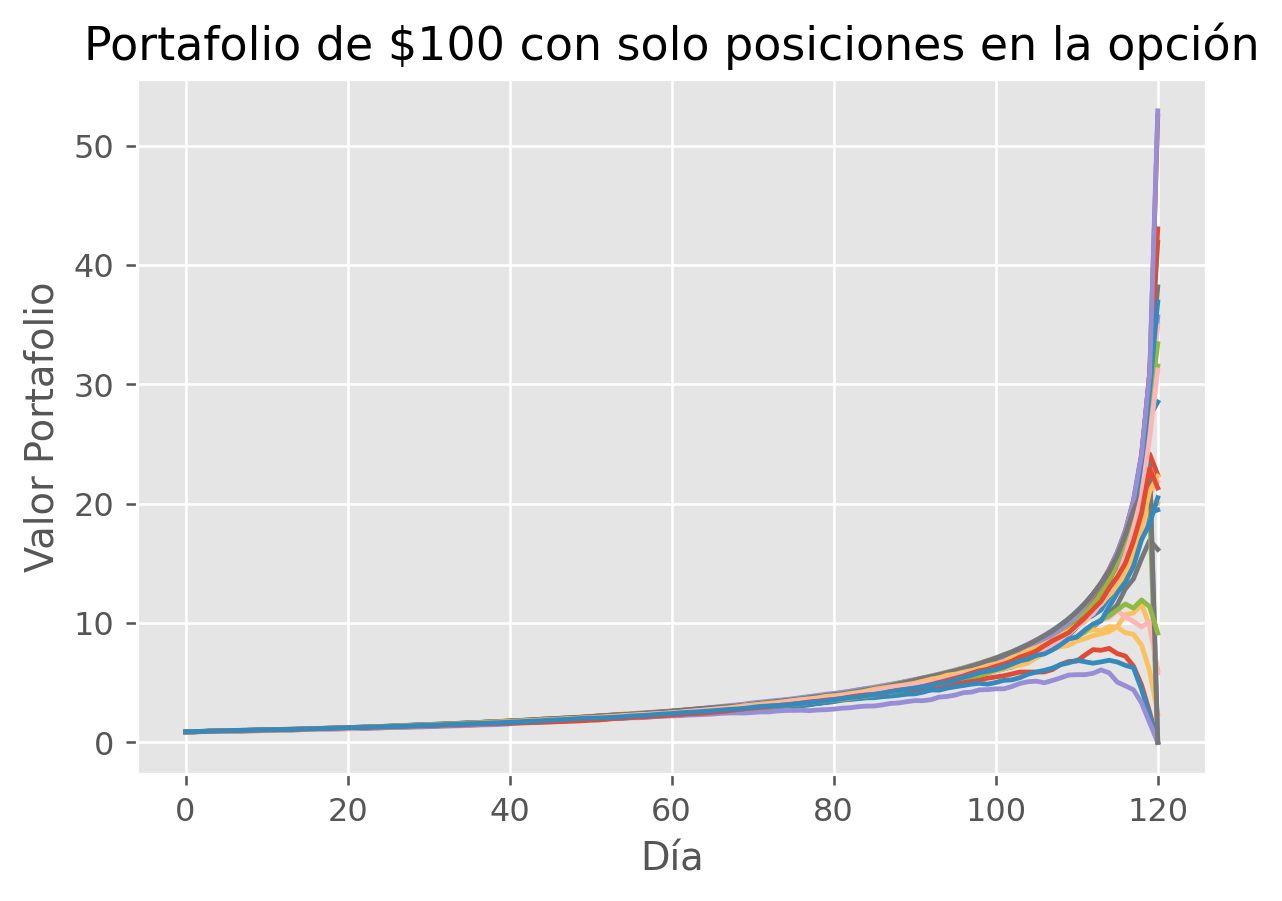

In [213]:
tiempo = np.linspace(0, T,finura, endpoint = True)
for (columnName, columnData) in caminos.iteritems():

    Precio_Opcion = f(columnData.to_numpy(),np.arange(T+1),E1,E2,T, sigma, risk_free )
    plt.plot(Precio_Opcion)
    plt.xlabel("Día"); plt.ylabel( "Valor Portafolio"); plt.title("Portafolio de $100 con solo posiciones en la opción")
plt.savefig("Precio de la Opcion.png", dpi =300)
precio_inicial_opcion = Precio_Opcion[0]

m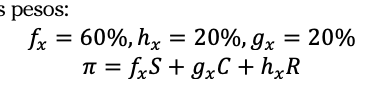

In [220]:
#####pesos
fx = 0.45
hx=0.15
gx = 1 - hx - fx
Disponible = 100
hx = hx*Disponible
gx = Disponible*gx/precio_inicial_opcion


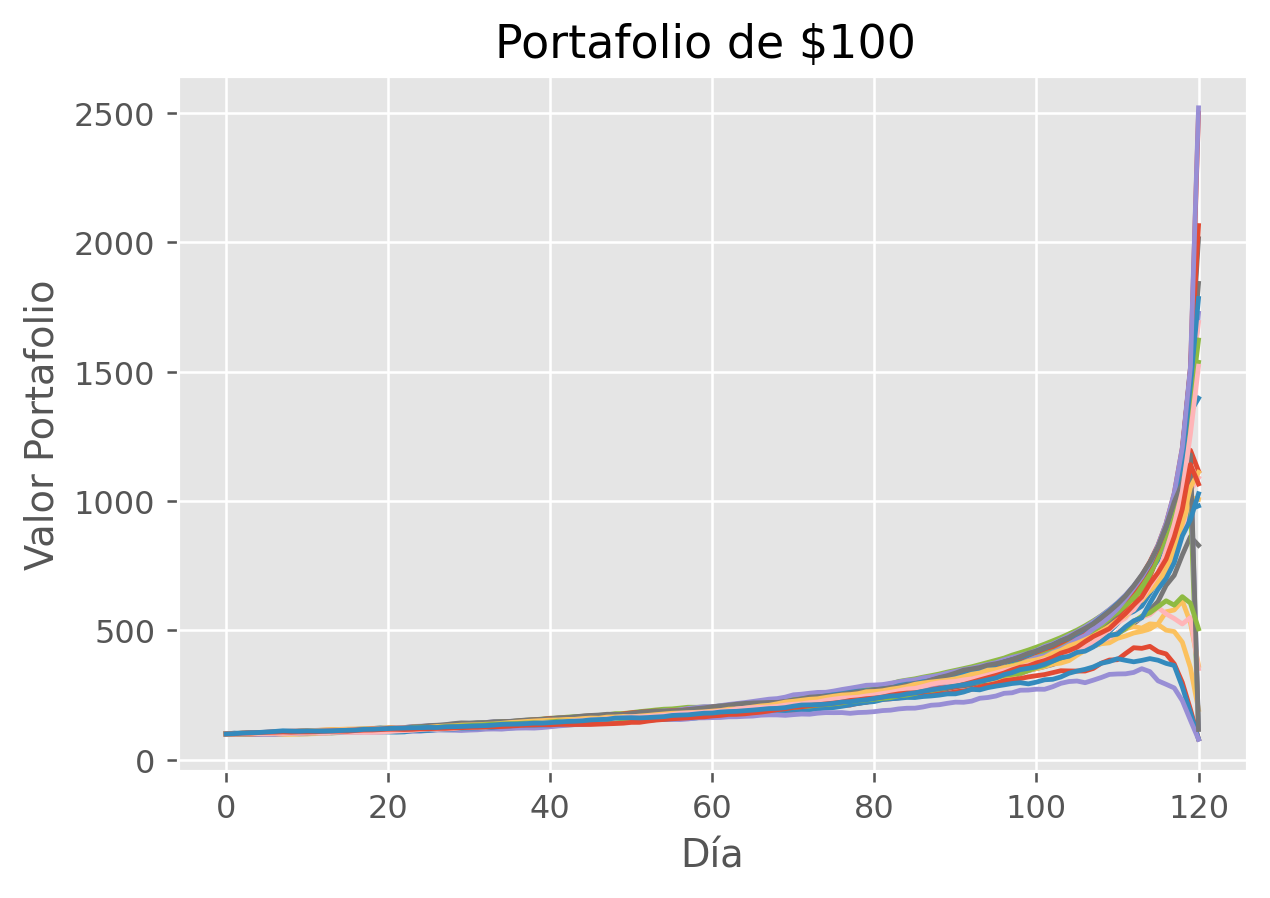

In [221]:
for (columnName, columnData) in caminos.iteritems():
    Precio_Activo = columnData.to_numpy()
    Precio_Opcion = f(Precio_Activo,np.arange(T+1),E1,E2,T, sigma, risk_free )
    Valor_Portafolio = fx*Precio_Activo + gx*Precio_Opcion + hx*sin_riesgo
    plt.plot(Valor_Portafolio)
    plt.xlabel("Día"); plt.ylabel( "Valor Portafolio"); plt.title("Portafolio de $100 ")

plt.savefig("Portafolio Total.png", dpi =300)
    
    